In [ ]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from natasha import Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger, Doc

from sentence_transformers import SentenceTransformer
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier

# Лемматизация

In [2]:
df=pd.read_excel('Проверка на дубли (внутри как полное совпадение, так и частичное).xlsx')

In [3]:
df = df.drop(columns=["Номер", "Статус"])
df = df.assign(Предложения=lambda x: (x['Название'] + ' ' + x['Описание']).str.lower())
df=df.drop(columns=['Название', 'Описание'])

In [4]:
orig_df = df['Предложения'].astype(str).tolist()  # Все предложения как есть
orig_df = [s.replace("\n","").replace("\t"," ") for s in orig_df]
orig_df = pd.DataFrame(orig_df)

In [5]:
def split_text(text): return text.split()
orig_df['words'] = orig_df[0].apply(split_text)
df=orig_df.drop(columns=0)

In [6]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

In [7]:
def lemmatize_words(words):
    doc = Doc(' '.join(words))
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    return [token.lemma for token in doc.tokens]

In [8]:
df['lemmatized_words'] = df['words'].apply(lemmatize_words)

In [9]:
STOP = {
    'в', 'на', 'с', 'по', 'к', 'из', 'у', 'от', 'до',
    'за', 'для', 'о', 'об', 'со', 'во', 'не', 'ни', 'под',
    'над', 'перед', 'при', 'через', 'между', "что", "или", '.', 'и'
}

In [10]:
def word_remover(words, stop_words): return [word for word in words if word not in stop_words]

df['filtered_words'] = df['lemmatized_words'].apply(lambda words: word_remover(words, STOP))

In [11]:
df.to_csv('after_lemma.csv', index=False, encoding='utf-8')

# Разметка

In [12]:
data = pd.read_csv('after_lemma.csv')

In [13]:
original_data = data['filtered_words']

In [ ]:
# Векторизация (без предобработки)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(original_data)

# Поиск похожих пар
threshold = 0.4
similar_pairs = []
for i in range(len(original_data)):
    for j in range(i+1, len(original_data)):
        sim = cosine_similarity(X[i], X[j])[0][0]
        if sim > threshold:
            similar_pairs.append({
                'ID_1': i,
                'ID_2': j,
                'Сходство': round(sim, 2),
                'Текст_1': original_data[i],
                'Текст_2': original_data[j]
            })

In [15]:
output_data = []
for idx, text in enumerate(original_data):

    related = []
    for pair in similar_pairs:
        if pair['ID_1'] == idx or pair['ID_2'] == idx:
            related_id = pair['ID_2'] if pair['ID_1'] == idx else pair['ID_1']
            related.append(f"{related_id}: {pair['Текст_2'] if pair['ID_1'] == idx else pair['Текст_1']} (сходство: {pair['Сходство']})")
    
    output_data.append({
        'ID': idx,
        'Исходное предложение': text,
        'Похожие предложения': "; ".join(related) if related else "Нет"
    })

df = pd.DataFrame(similar_pairs)
df.to_csv('result.csv', index=False, encoding='utf-8')

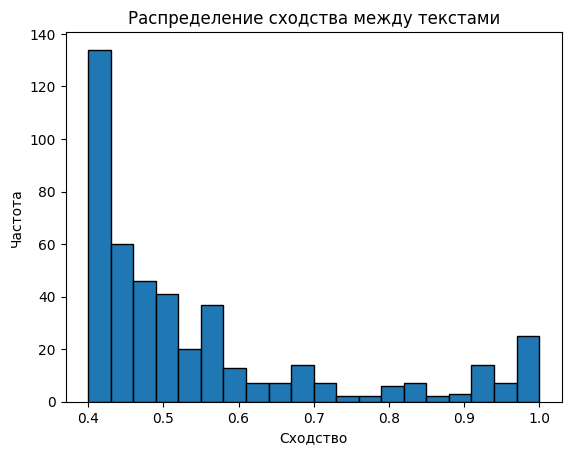

In [16]:
import matplotlib.pyplot as plt

similarities = [pair['Сходство'] for pair in similar_pairs]

plt.hist(similarities, bins=20, edgecolor='black')
plt.xlabel('Сходство')
plt.ylabel('Частота')
plt.title('Распределение сходства между текстами')
plt.show()

# Обучение

In [17]:
data = pd.read_csv('result.csv')
texts1 = data['Текст_1'].values
texts2 = data['Текст_2'].values
targets = data['Сходство'].values

In [18]:
def convert_to_class(value):
    if value < 0.3:
        return 0
    elif value < 0.7:
        return 1
    else:
        return 2


In [19]:
class_targets = np.array([convert_to_class(v) for v in targets])

tfidf = TfidfVectorizer(max_features=5000)
X1 = tfidf.fit_transform(texts1).toarray()
X2 = tfidf.transform(texts2).toarray()

In [20]:
def create_features(text1, text2, emb1, emb2):
    words1 = text1.split()
    words2 = text2.split()
    common_words = set(words1) & set(words2)
    features = [
        np.dot(emb1, emb2),
        len(common_words) / (len(set(words1) | set(words2)) + 1e-6),
        abs(len(words1) - len(words2)),
        (len(words1) + len(words2)) / 2,
        len(words1),
        len(words2),
        len(common_words)
    ]
    return np.array(features)


In [21]:
X = np.array([create_features(t1, t2, e1, e2) for t1, t2, e1, e2 in zip(texts1, texts2, X1, X2)])

unique_classes, counts = np.unique(class_targets, return_counts=True)
valid_classes = [cls for cls, count in zip(unique_classes, counts) if count >= 10]
mask = np.isin(class_targets, valid_classes)
X = X[mask]
class_targets = class_targets[mask]

In [22]:
X_train, X_temp, y_train, y_temp = train_test_split(X, class_targets, test_size=0.4, random_state=42, stratify=class_targets)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [ ]:
model_params = {
    "iterations": 1000,
    "learning_rate": 0.03,
    "depth": 4,
    "loss_function": "MultiClass",
    "eval_metric": "TotalF1",
    "task_type": "CPU",
    "early_stopping_rounds": 100,
    "verbose": 100
}

model = CatBoostClassifier(**model_params)
model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

0:	learn: 0.9816984	test: 1.0000000	best: 1.0000000 (0)	total: 56.4ms	remaining: 56.3s
100:	learn: 0.9852941	test: 1.0000000	best: 1.0000000 (0)	total: 75.3ms	remaining: 670ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1
bestIteration = 0

Shrink model to first 1 iterations.


In [24]:
y_pred = model.predict(X_test)
print("\n=== Отчет по метрикам ===")
print(classification_report(y_test, y_pred, digits=4))


=== Отчет по метрикам ===
              precision    recall  f1-score   support

           1     0.9867    0.9737    0.9801        76
           2     0.8750    0.9333    0.9032        15

    accuracy                         0.9670        91
   macro avg     0.9308    0.9535    0.9417        91
weighted avg     0.9683    0.9670    0.9675        91

